# Newton Fractal — generate Fortran code from SymPy

In this notebook you define a SymPy expression `f(z)`. The notebook generates only the Fortran fragments that change when you edit `f` (the evaluation of `f` and `f'`) and embeds them into a static Fortran template that writes a PPM image of the Newton fractal.

Workflow:
1. Define `f(z)` as a SymPy expression (example: `z**3 - 1`).
2. Notebook generates Fortran fragments for Re(f), Im(f), Re(f'), Im(f'). These fragments are inserted into a static Fortran template.
3. Output: a static Fortran file `newton_fractal_static.f90` and a dynamic include `newton_dynamic.inc` you can compile.
4. After running the program, the image can be displayed.

Note: SymPy is required. If not installed, run:
```bash
python -m pip install sympy
```
To compile the generated Fortran code you need a Fortran compiler like `gfortran`. You can also inspect the generated code without compiling.

In [ ]:
# Imports
import sympy as sp
from sympy import I, fcode
from textwrap import dedent
from macrofor import api as mf
import pathlib

# Set Fortran style to F90
mf.set_fortran_style('f90')

print('SymPy version:', sp.__version__)
print('Fortran style:', mf.get_fortran_style().format)

SymPy version: 1.14.0


## 1) Parameters and function definition
Define image size and coordinate window below. Edit `f(z)` to change the function (e.g. `z**3 - 1`).

In [66]:
# User-configurable parameters
width = 800
height = 800
xmin = -1.5
xmax =  1.5
ymin = -1.5
ymax =  1.5
maxiter = 30
supersample = 4  # Number of subpixel samples per axis (supersample x supersample per pixel)

# === Define the complex function f(z) here ===
z = sp.symbols('z')
f = z**3 - 1    # <-- edit this line to change the function
# ==========================================
f

z**3 - 1

## 2) Build SymPy expressions for Re/Im of f and f' (in x,y)

Newton's method is an iterative procedure to find roots of a function. For a complex function f(z) with z ∈ ℂ, the iteration rule is:

    z_{n+1} = z_n - f(z_n) / f'(z_n)

where f'(z) is the derivative of f with respect to z. In the context of Newton fractals, this iteration is performed for each image pixel (starting value z₀) until convergence or a maximum number of steps is reached.

For numerical implementation, z, f(z), and f'(z) are split into real and imaginary parts:

    z = x + i*y
    f(z) = a + i*b
    f'(z) = c + i*d

This allows the Newton iteration to be performed using real arithmetic.

We substitute `z = x + i*y` and extract the real and imaginary parts for `f` and `f'`.

In [67]:
# symbolic variables
x, y = sp.symbols('x y', real=True)
z_xy = x + I*y

# f and derivative f'
f_xy = sp.simplify(f.subs(z, z_xy))
df = sp.diff(f, z)
df_xy = sp.simplify(df.subs(z, z_xy))

# explicit real and imaginary parts
re_f = sp.re(f_xy)
im_f = sp.im(f_xy)
re_df = sp.re(df_xy)
im_df = sp.im(df_xy)

print('f(z) =', f)
print('Re(f) =', re_f)
print('Im(f) =', im_f)

print('df(z) =', df)
print('Im(f) =', im_df)
print('Re(f) =', re_df)

f(z) = z**3 - 1
Re(f) = x**3 - 3*x*y**2 - 1
Im(f) = 3*x**2*y - y**3
df(z) = 3*z**2
Im(f) = 6*x*y
Re(f) = 3*x**2 - 3*y**2


## 3) Convert SymPy expressions to Fortran RHS strings and wrap with macrofor helpers
The Newton iteration in components:

    denom = c^2 + d^2
    nr = a*c + b*d
    ni = b*c - a*d
    x_new = x - nr / denom
    y_new = y - ni / denom

The previously computed real and imaginary parts of f(z) and f'(z) are used as variables a, b, c, d in Fortran. The iteration follows the formulas above. Convergence is checked by the distance between two iteration steps:

    dist = sqrt((x_new - x)^2 + (y_new - y)^2)

If dist < tol (tolerance), the iteration for this point stops.

The number of iteration steps is used as the value for the image display.

We use `sympy.fcode` to generate Fortran expressions and then `macrofor.api.equalf` to produce assignment lines. Only these lines are written to the dynamic include file.

In [68]:
def fortran_rhs(expr):
    # produce a Fortran assignment to a temporary name and extract the RHS
    s = fcode(expr, assign_to='TMP', source_format='free')
    rhs = s.split('=',1)[1].strip()
    return rhs

# Build assignment RHS strings
a_rhs = fortran_rhs(re_f)
b_rhs = fortran_rhs(im_f)
c_rhs = fortran_rhs(re_df)
d_rhs = fortran_rhs(im_df)

# Wrap with macrofor helpers to produce canonical assignment lines
a_line = mf.equalf('a', a_rhs)
b_line = mf.equalf('b', b_rhs)
c_line = mf.equalf('c', c_rhs)
d_line = mf.equalf('d', d_rhs)

dynamic_lines = [a_line, b_line, c_line, d_line]
dynamic_text = "\n".join(dynamic_lines) + "\n"

print('Generated dynamic fragment (for include file):')
print(dynamic_text)

Generated dynamic fragment (for include file):
a = x**3 - 3*x*y**2 - 1
b = 3*x**2*y - y**3
c = 3*x**2 - 3*y**2
d = 6*x*y



## 4) Write dynamic include and static Fortran file
The static file contains the Newton iteration, grid setup and PGM dump. The dynamic include (`newton_dynamic.inc`) contains only the `a=...`, `b=...`, `c=...`, `d=...` assignments produced above.

In [ ]:
# Paths
notebook_dir = pathlib.Path('.')
dyn_path = notebook_dir / 'newton_dynamic.inc'
static_path = notebook_dir / 'newton_fractal_static.f90'

# Write dynamic include
dyn_path.write_text(dynamic_text)
print('Wrote dynamic include:', dyn_path.resolve())

# Static Fortran template (uses include to import a,b,c,d evaluations)
static_template = dedent(f'''
program newton_fractal
  use, intrinsic :: iso_fortran_env, only: int8
  implicit none
  integer, parameter :: width = {width}, height = {height}
  integer, parameter :: supersample = {supersample}
  integer :: i, j, si, sj, iter, maxiter
  double precision :: xmin, xmax, ymin, ymax
  double precision :: zr, zi, nz_re, nz_im
  double precision :: a, b, c, d, denom, nr, ni
  double precision :: x, y
  double precision :: tol, dist
  integer :: val
  integer, dimension(width,height) :: img
  double precision :: sumval
  double precision :: dx, dy

  tol = 1.0d-8

  xmin = {xmin}d0
  xmax = {xmax}d0
  ymin = {ymin}d0
  ymax = {ymax}d0
  maxiter = {maxiter}

  dx = (xmax - xmin) / (width - 1)
  dy = (ymax - ymin) / (height - 1)

  do j = 1, height
    do i = 1, width
      sumval = 0.0d0
      do sj = 0, supersample-1
        do si = 0, supersample-1
          zr = xmin + (i-1 + (si+0.5d0)/supersample) * dx
          zi = ymin + (j-1 + (sj+0.5d0)/supersample) * dy
          x = zr
          y = zi
          iter = 0
          do while (iter < maxiter)
            ! include dynamic evaluation of f and f' (a,b,c,d)
            include 'newton_dynamic.inc'
            ! static Newton update (expressed with a,b,c,d)
            denom = c*c + d*d
            nr = a*c + b*d
            ni = b*c - a*d
            nz_re = zr - nr/denom
            nz_im = zi - ni/denom
            ! Check convergence
            dist = sqrt((nz_re - zr)**2 + (nz_im - zi)**2)
            if (dist < tol) exit
            zr = nz_re
            zi = nz_im
            x = zr
            y = zi
            iter = iter + 1
          end do
          sumval = sumval + dble(iter)
        end do
      end do
      val = int(255.0d0 * sumval / (maxiter * supersample * supersample))
      img(i,j) = val
    end do
  end do

  call write_ppm_p6('newton_out.ppm', img, width, height)
end program newton_fractal
''')

fortran_source = static_template
static_path.write_text(fortran_source)
print('Wrote static Fortran file:', static_path.resolve())

Wrote dynamic include: C:\Python\macrofor\docs\newton_dynamic.inc
Wrote static Fortran file: C:\Python\macrofor\docs\newton_fractal_static.f90


## 5) Compile & run (examples)
Use your Fortran compiler (e.g. `gfortran`). Example commands for PowerShell (Windows):
```powershell
gfortran newton_fractal_static.f90 write_ppm_p6.f90 -o newton_fractal.exe
.\newton_fractal.exe
```

or Bash (Linux)
```bash
gfortran newton_fractal_static.f90 write_ppm_p6.f90 -o newton_fractal
./newton_fractal
```

The program will write `newton_out.ppm` in the same folder.

## 6) Preview the generated PPM (after compile & run)
If `newton_out.ppm` has been generated you can display it using Python/Pillow:

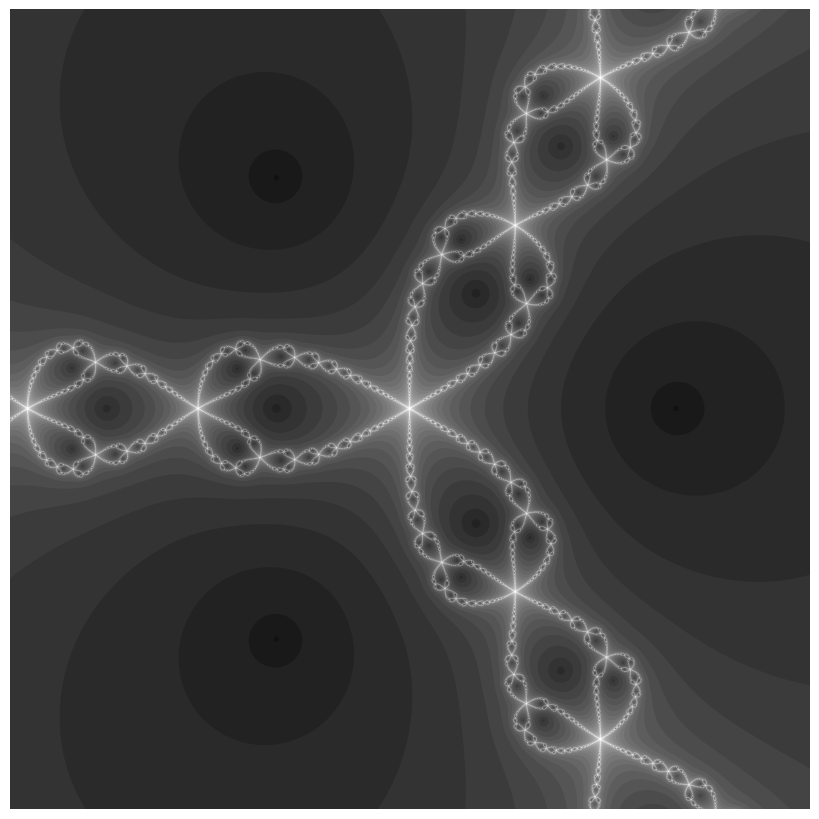

In [70]:
from helper import read_ppm_p6
import matplotlib.pyplot as plt

img_path = pathlib.Path('newton_out.ppm')

if img_path.exists():
    img = read_ppm_p6(str(img_path))

    dpi = 100  
    h, w, _ = img.shape
    figsize = (w / dpi, h / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1]) 
    ax.imshow(img)
    ax.axis("off")
    plt.show()

else:
    print('File newton_out.ppm not found. Compile and run the Fortran program to generate it.')